In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from ipywidgets import interact, IntSlider
import copy

# import sys
# sys.path.append("BayesianOptimization/")
from bayes_opt import BayesianOptimization
from matplotlib import gridspec
sns.set_context('talk')
sns.set_style('whitegrid')
%matplotlib inline

def posterior(bo, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma2 = bo.gp.predict(np.linspace(xmin, xmax, 1000).reshape(-1, 1), eval_MSE=True)
    return mu, np.sqrt(sigma2)

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16,8))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r', clip_on=False)
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((0., 1.5))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x.reshape((-1, 1)), bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), 'd', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', 
             markeredgecolor='k', markeredgewidth=1, clip_on=False)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [5]:

# Our Objective Function
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

x = np.linspace(-2, 10, 1000)
y = target(x)
bo = BayesianOptimization(target, {'x': (-2, 10)})

# Gaussian Process Parameters
gp_params = {"corr": "cubic", "theta0": 0.1, "thetaL": None, "thetaU": None, "random_start": 1}
# Give the Model 3 random points to initialize
bo.maximize(init_points=3, n_iter=0, acq='ei', xi=0.05, **gp_params) 

n_samp = 15
bo_list = [copy.deepcopy(bo)]
for iter in range(n_samp):
    bo.maximize(init_points=0, n_iter=1, xi=.05)  # random init, pts to add, parameter
    bo_list+=[copy.deepcopy(bo)]

def plot_specific(n):
    assert n< len(bo_list)
    plot_gp(bo_list[n], x, y)
    


Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    0.36439 |    9.2279 | 
    2 | 00m00s |    1.02513 |    6.1015 | 
    3 | 00m00s |    0.92399 |    0.6353 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    4 | 00m00s |    0.73329 |    3.9083 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    5 | 00m00s |    0.20166 |   -2.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    6 | 00m00s |    0.93977 |    6.9173 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    7 | 00m00s |    1.34801 |    1.7454 | 
Bayesian Optimization
-----------------------------------------


In [29]:
from traitlets.config.manager import BaseJSONConfigManager
path = "E:/ProgramFiles_w/Engineering/Anaconda/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
# # cm.update('livereveal', {
# #         'width': 960,
# #         'height': 700
# # })
#               'theme': 'sky',
#               'transition': 'zoom',
cm.update('livereveal', {'start_slideshow_at': 'selected'})

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

{'start_slideshow_at': 'selected'}

# Thurston Sexton
Sandia NL Interview

9/27/2016

- Optimization
- Numerical Modeling
- Machine Learning




## Learning Human Search Strategies 
### From a Crowdsourcing Game

**Thurston Sexton, Max Yi Ren**

*Design Informatics Lab*  
*Dept. of Mechanical and Aerospace Engineering*  
*Arizona State University*  

Presented at IDETC 2016 (Charlotte, Aug.22)  
Submitted to ASME JMD *(under review)*

### Overview
- **Why *human* search strategy?**
- Bayesian Optimization (IBO)
- Inverse Bayesian Optimization (IBO)
- Case Study: Learning from others vs by one's-self
- IBO vs. Inverse Reinforcement Learning

### Why *human* search strategy?

Human beings can **sometimes outperform** optimization algorithms at searching

- e.g. Figuring out how to play a game well.

    - Machine achieved *lower* than human level performance after 38 days of continuous play of ATARI Frostbite (Mnih et al.2015)
    - State-of-the-art deep learning achieves 3.5% of human performance on this game after the same amount of game play (2 hours) 

*Lake et al., “Building Machines That Learn and Think Like
People”, arXiv (July 2016)*

<img src="./ecoracer.png", width="90%">
ecoracer.herokuapp.com

### Why do humans succeed where algorithms fail?
- **Knowledge** -  Prior information (or physical intuition)? 
- **Meta Game** - ability in absraction?
- **Learning to Learn** - Self improvement/strategic insight?

### What about Crowdsourcing?
- **Currently**: wait for *good solutions* to arise by watching many players attempt solutions.
    - *a.k.a. smart people spending lots of time on a game*

- **What if**: wait for *good search strategies* by observing fast-improving players' decisions. 
    - *a.k.a. smart people willing to at least try the game* 
    

**$\rightarrow$ Problem:** If we assume Humans search using an optimization scheme (e.g. Bayesian Optimization) with parameters informed by prior knowledge (their "strategy"), can we recover those parameters using their search trajectory? 

### Overview
- Why *human* search strategy?
- **Bayesian Optimization (BO)**
- Inverse Bayesian Optimization (IBO)
- EcoRacer - Crowdsourced Strategy

### What is Bayesian Optimization?
Efficient Global Optimization (EGO) is excellent at optimizing expensive functions with minimal calls. 
1. sample the solution space
2. estimate/update a Gaussian Process (kriging) model
3. find new sample by maximizing a utility/aquizition function
4. repeat 2,3

### What is BO? Simple 1-D Example
$$ \max_x f(x)\quad \text{where} \quad f(x) = e^{-(x-2)^2} + \frac{1}{10}e^{-(x-6)^2} + \frac{1}{x^2+1}$$

For the set of available samples ${\bf X}_k$ and associated objective values ${\bf f}_k$, $$h_k :=<{\bf X}_k, {\bf f}_k>$$

Then given a utility function $Q_{EI}$, 
$$ x_{k+1} = \text{argmax}_{x\in \mathcal{X}}Q_{EI}(x;h_k, \lambda)$$

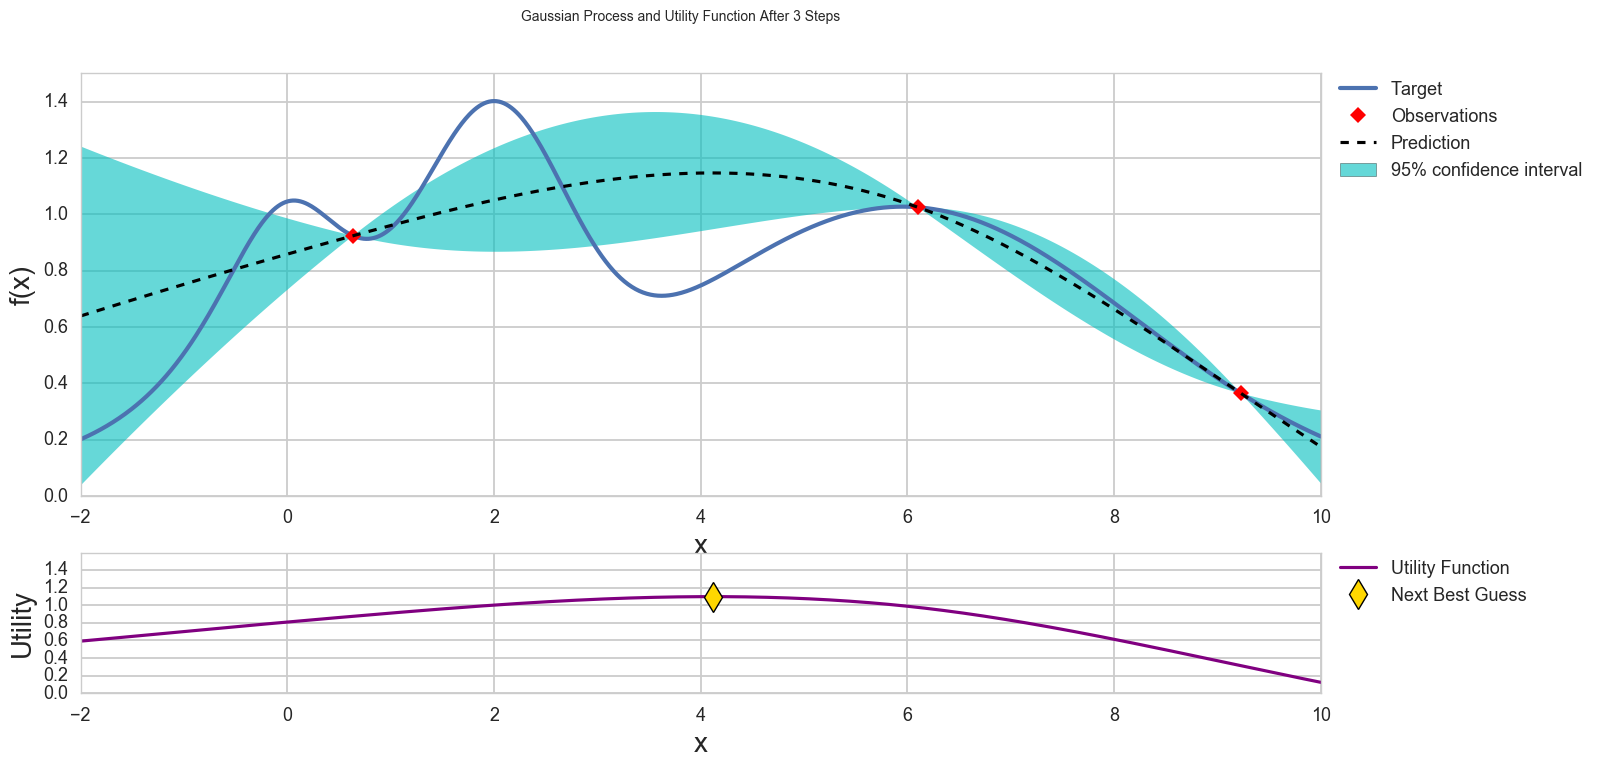

In [6]:
slider = IntSlider(min=0, max=n_samp-1, step=1)
interact(plot_specific, n=slider)
slider.layout.width = '70%'

### What is BO? Pros/Cons

Search is governed by GP parameters ($\lambda$) and the probabilistic nature of optimizing EI (strict vs non  $\rightarrow \alpha$). 

- fewer objective function calls
- creates *"surrogate model"* with cheap evaluation
- estimate of certainty is included
- matches actual human search in 1-D (*Borji & Itti 2013*)

but...
- needs good GP parameters for efficiency
- curse of dimensionality

*we'll be coming back to these*

### Overview
- Why *human* search strategy?
- Bayesian Optimization (BO)
- **Inverse Bayesian Optimization (IBO)**
- EcoRacer - Crowdsourced Strategy

We want to recover $\lambda$ (and $\alpha$) from an observed trajectory ${\bf h}$

Assume $\lambda, \alpha$ is static. The Log-likelihood of a GP parameter can be defined as:

$$L(\lambda, \alpha) = \sum l(\alpha, \lambda, {\bf X},{\bf f})$$

where $l$ is the log-probability of every new sample *given* all previous samples/responses.
**Every calculation of $l$ needs *integration* over $x$**

### IBO: Does it work? 

**Rosenbrock 30-D** with four settings...how many samples do we need? 

<img src="./ibo.png", width="90%">

IBO quickly recognizes the true BO settings **unless** BO is behaving ~ random sampling (high $\lambda$)

### IBO: Is it efficient? 

Generally solvers find a $\lambda$ at each iteration (adaptive) without prior knowledge (Maximum Likelihood Estimate)


<img src="./self-adapt-vs.png", width="60%">




### IBO: Is it efficient? 
Adaptive (MLE) parameters do not quickly converge to an optimal setting. 

<img src="./fracs.png", width="70%">
*over 30 trials*

### Overview
- Why *human* search strategy?
- Bayesian Optimiztion
- Inverse Bayesian Optimization (IBO)
- **EcoRacer - Crowdsourced Strategy**

<img src="./ecoracer_new.png", width="100%">

### EcoRacer
#### Part design (gear ratio), part control (trinary signal)

Treated as a design optimization problem means **very high** dimensionality. 
- 18160 "ticks" where a descision can be made, spread over 36s
- Nearly impossible to do BO without dimension reduction. 
- Previously: inputs like hill gradient, time since beginning, velocity, etc.

How do Humans "reduce the dimensionality" of a problem? *Salient features*, with minimal multi-tasking. 

$\rightarrow$**Independant Component Analysis (ICA)**

<img src="./comp_sorted.png", align="right", width="40%">
Unlike PCA (maximize variance in orthogonal bases), ICA performs the task of *blind source separation*. 

For ICA finds an assumed number of *source signals* such that they combine to produce the observed signals having **minimum shared information** (K-L divergence). 

Note the bases roughly correspond to track locations when sorted. 

(30-D projection)

#### Example signal recovery
Nearly all of the original information can be recovered using only 30 inputs and thresholding. 
<img src="./ica-recover.png", width="60%">
So does it work?

#### How does BO do if it learns a "good player's" strategy with IBO?

1. Model Problem Space (ICA)  
2. Find $\hat{\lambda}$ using IBO  
3. Compare new BO to standard BO and players

<img src="./result_res_new.png", width="100%">

## Summary and Future

### Comparison with IRL: 
IBO shares some motivation and approach with Inverse Reinforcement Learning (ML). 
* **Ask: Why do people solve it this way?** - learn optimal control strategy

However, because IBO needs all previous state/action pairs to sample, it is *non-Markovian*. 
* **Ask: How did people figure out this solution? ** - learn optimal optimization parameters

How is this different? Experts are not needed! More efficient utilization of players' time once gamification/mechanism design has been implemented. 

**Potentially, IBO could speed up future solution search based on experience learned from others. **

### Special Thanks to: 
- ODE Lab at Univ. of Michigan
- NSF CMMI-1266184
- All EcoRacer Players!

### Questions?

## Numerical Modeling & Simulation
### Solving PDE's

Ferromagnetic Phase Separation

MAE 598 (Spring 2016, Dr Yang Jiao)

CFD spinny thingies

MAE 561 (Fall 2015, Dr. Marcus Hermann)